# Laboratory on Gait Analysis
_Digital Forensics and Biometrics A.A. 2025/2026_

Lecturer: prof. **Simone Milani** (simone.milani@dei.unipd.it)

Teaching Assistants: **Mattia Tamiazzo** (mattia.tamiazzo.1@phd.unipd.it); **Luca Domeneghetti** (luca.domeneghetti@studenti.unipd.it)

## 2. Environment Setup

We import the necessary libraries. We will use `scipy` for signal processing (filtering and FFT) and `torch` for building the neural network. Along those, some utility functions from `sklearn` will be used.

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# signal processing
from scipy.signal import butter, lfilter, freqs
from scipy.fft import fft
from scipy.stats import iqr, entropy

# PyTorch Deep Learning framework
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary

# scikit-learn utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Computation Device: {device}")

Computation Device: cuda


## 3. Signal preprocessing

Accelerometers measure **total acceleration**, which is the sum of:
1.  **Body acceleration:** the actual movement performed by the user (_dynamic_).
2.  **Gravity:** the constant acceleration caused by the earth's mass (_static_ and with _low frequency_).

To analyze movement correctly, we must separate these components using a **Low-Pass Filter** (Butterworth).

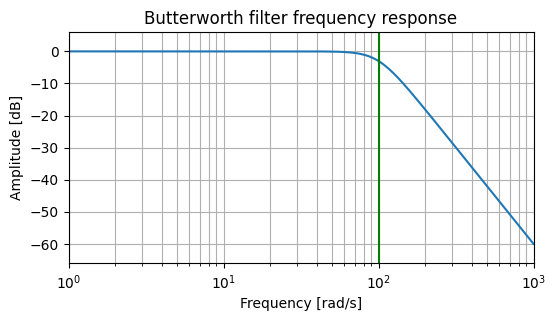

In [4]:
def plot_butterworth(cutoff=100):
    b, a = butter(3, cutoff, btype='low', analog=True)
    w, h = freqs(b, a)

    plt.figure(figsize=(6,3))
    plt.semilogx(w, 20 * np.log10(abs(h)))
    plt.title('Butterworth filter frequency response')
    plt.xlabel('Frequency [rad/s]')
    plt.ylabel('Amplitude [dB]')
    plt.margins(0, 0.1)
    plt.grid(which='both', axis='both')
    plt.axvline(cutoff, color='green') # cutoff frequency
    plt.show()

plot_butterworth()

In [5]:
def separate_gravity(data, fs=50):
    """
    Separates the gravity component from the body acceleration.
    Gravity is low-frequency (slow changing), Body Acc is high-frequency.
    """
    
    # calculate the cutoff frequency normalized to Nyquist
    nyquist_freq = 0.5 * fs
    cutoff_freq = 0.3  # 0.3 Hz cutoff
    normalized_cutoff = cutoff_freq / nyquist_freq
    
    # design the Butterworth filter
    b, a = butter(3, normalized_cutoff, btype='low', analog=False)
    
    # apply filter
    gravity = lfilter(b, a, data, axis=0)
    body_acc = data - gravity
    
    return body_acc, gravity

## 5. Feature Extraction

For every window of data (128 samples per window), we extract a single vector of additional features. This serves as a way to better describe the data and abstract from the pure raw signals.

**Features extracted per axis:**
1.  **Temporal:** mean, standard deviation, min, max, energy, IQR (Interquartile Range).
2.  **Frequency (FFT):** dominant frequency, spectral energy, spectral entropy.
3.  **Physics measurements:** jerk (smoothness), magnitude (intensity), angle (posture).

### Process raw 3D signal

A 3-dimentional signal is made up of three components, one for each axis (X, Y and Z). For each axis we compute a series of statistical features:
- mean
- standard deviation
- max value
- min value
- **Interquartile Range (IQR)**: the difference between the 75th and 25th percentile of the data
- **energy**: $\frac{1}{N}\sum_i^N (x_i)^2$

In [6]:
def process_raw_signal(signal):
    """
    Input: A signal of shape (128, 3) containing X,Y,Z components
    Output: A 1D array of calculated features on a single signal.
    """
    sig_mean = np.mean(signal, axis=0)
    sig_std = np.std(signal, axis=0)
    sig_max = np.max(signal, axis=0)
    sig_min = np.min(signal, axis=0)
    sig_iqr = iqr(signal, axis=0)
    sig_energy = np.sum(signal**2, axis=0) / len(signal)

    return np.concatenate([sig_mean, sig_std, sig_max, sig_min, sig_iqr, sig_energy])

### Process magnitude signal

The **magnitude** of a signal is obtained by computing the algebraic norm over the axis components.
$$||\text{signal}_{xyz}||=\sqrt{x^2 + y^2 + z^2}$$

From the magnitude, we compute similar statistical features to those of raw signals (except for the energy).

In [7]:
def process_magnitude_signal(signal):
    """
    Input: A signal of shape (128, 3) containing X,Y,Z components.
    Output: A 1D array of calculated features on a single magnitude signal.
    """
    mag_signal = np.linalg.norm(signal, axis=1)
    
    mag_sig_mean = np.mean(mag_signal)
    mag_sig_std= np.std(mag_signal)
    mag_sig_max = np.max(mag_signal)
    mag_sig_min = np.min(mag_signal)
    mag_sig_iqr = iqr(mag_signal)

    return [mag_sig_mean, mag_sig_std, mag_sig_max, mag_sig_min, mag_sig_iqr]

### Frequency features
Analyzing data in a frequency domain allows to infer those features associated with the periodicity of the signal.

In our case, we are interested in the following frequency features:
- spectral mean
- spectral entropy
- dominant frequency

In [8]:
def process_frequency_domain(signal):
    """
    Input: A signal of shape (128, 3) containing X,Y,Z components
    Output: A 1D array of calculated frequency features on a single signal.
    """
    frequency_features = []
    
    for axis in range(3):
        col = signal[:, axis]
        
        # Compute Fast Fourier Transform
        # We take the first half because real-valued FFT is symmetric
        fft_values = np.abs(fft(col))[:len(signal)//2]
        
        # Feature 1: Spectral Mean (Average energy in freq domain)
        frequency_features.append(np.mean(fft_values))
        
        # Feature 2: Spectral Entropy (Measure of signal complexity)
        # Normalize to treat as a probability distribution
        psd = fft_values / (np.sum(fft_values) + 1e-9)
        frequency_features.append(entropy(psd))
        
        # Feature 3: Dominant Frequency (Index of max power)
        frequency_features.append(np.argmax(fft_values))

    return frequency_features

### Signal correlation
By looking at **correlation coefficients** between different signal's components we estimate _"how much"_ the three axes (X,Y,Z) relate to each other.

In [9]:
def signal_correlation(signal):
    """
    Input: A signal of shape (128, 3) containing X,Y,Z components
    Output: A 1D array of calculated correlations between X-Y, X-Z, Y-Z axes.
    """
    XY_corr = np.corrcoef(signal[:,0], signal[:,1])[0,1]
    XZ_corr = np.corrcoef(signal[:,0], signal[:,2])[0,1]
    YZ_corr = np.corrcoef(signal[:,1], signal[:,2])[0,1]

    return [XY_corr, XZ_corr, YZ_corr]

### Angle between signals
By taking the mean value of a signal (with respect to its X,Y,Z components) we obtain a vector pointing in the "mean direction" of the overall signal.

By inverting the formula
$$\textbf{a}\cdot\textbf{b} = ||\textbf{a}||\,||\textbf{b}|| \cos{\theta}$$
we get
$$\theta = \arccos\left(\frac{\textbf{a}\cdot\textbf{b}}{||\textbf{a}||\,||\textbf{b}||}\right)$$

In [10]:
def angle_signals(sig1, sig2):
    mean_sig1 = np.mean(sig1, axis=0)
    mean_sig2 = np.mean(sig2, axis=0)
    
    numerator = np.dot(mean_sig1, mean_sig2)
    denominator = np.linalg.norm(mean_sig1) * np.linalg.norm(mean_sig2) + 1e-9
    angle = np.arccos(np.clip(numerator/denominator, -1.0, 1.0))

    return angle

In [11]:
def extract_features(window):
    """
    Input: A window of shape (128, 9) containing:
           [BodyAcc (3), Gyro (3), TotalAcc (3)]
    Output: A 1D array of calculated features.
    """
    features = []
    
    body_acc = window[:, 0:3]
    gyro = window[:, 3:6]
    total_acc = window[:, 6:9]
    
    # derive "jerk" signals (derivative of acceleration/gyro)
    # use padding so the length remains 128!
    acc_jerk = np.diff(body_acc, axis=0, prepend=body_acc[0:1, :])
    gyro_jerk = np.diff(gyro, axis=0, prepend=gyro[0:1, :])

    
    # --- TIME DOMAIN STATISTICS ---
    
    # list of all 3-axis signals to process
    multi_axis_signals = [body_acc, gyro, acc_jerk, gyro_jerk]
    for signal in multi_axis_signals:
        features.extend(process_raw_signal(signal))
        features.extend(process_magnitude_signal(signal))


    # --- FREQUENCY DOMAIN (FFT) ---
    
    # we only apply FFT to Body Acc and Gyro
    fft_inputs = [body_acc, gyro]
    
    for signal in fft_inputs:
        features.extend(process_frequency_domain(signal))


    # --- CORRELATION & ANGLE ---
    
    # correlation between body_acc axes (X-Y, X-Z, Y-Z)
    features.extend(signal_correlation(body_acc))

    # angle between body_acc vector and gravity vector (total_acc)
    features.append(angle_signals(total_acc, body_acc))

    # convert list to numpy array and handle any NaNs
    return np.nan_to_num(np.array(features))

## 6. Dataset Preparation

Here we download the UCI HAPT dataset.

In [12]:
dataset_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00341/HAPT%20Data%20Set.zip"
extract_folder = "HAPT_Dataset"
zip_path = extract_folder + ".zip"

if not os.path.exists(extract_folder):
    print("Downloading dataset...")
    !wget -q $dataset_url -O $zip_path
    print("Extracting...")
    !unzip -q $zip_path -d $extract_folder
    print("Dataset prepared.")
else:
    print("Dataset already exists.")

Dataset already exists.


### Obtain dataset contents

The dataset contains raw data spread accross different "experiments" carried out by different "users".

We read each individual user's experiment by looking at files `acc_exp##_user##.txt` and `gyro_exp##_user##.txt`.

Then, we match the labels (which have `start` and `end` indices) against the raw data.

Finally, we extract overlapping windows and compute the statistical features (described in Section 5).

In [13]:
def load_and_process_data(base_path, sampling_freq = 50, win_size = 128, win_overlap = 64):
    raw_path = os.path.join(base_path, "RawData")
    
    # Load labels
    labels_file = os.path.join(raw_path, "labels.txt")
    labels_df = pd.read_csv(labels_file, sep='\\s+', header=None)
    labels_df.columns = ["exp_id", "user_id", "activity_id", "start", "end"]
    
    raw_windows = []
    feature_vectors = []
    labels = []

    experiment_ids = labels_df['exp_id'].unique()
    
    for exp in experiment_ids:

        user = labels_df[labels_df['exp_id'] == exp]['user_id'].iloc[0]
        
        acc_file = f"acc_exp{exp:02d}_user{user:02d}.txt"
        gyro_file = f"gyro_exp{exp:02d}_user{user:02d}.txt"
        
        acc_data = pd.read_csv(os.path.join(raw_path, acc_file), sep='\\s+', header=None).values
        gyro_data = pd.read_csv(os.path.join(raw_path, gyro_file), sep='\\s+', header=None).values
        
        # separate Body Acc from Gravity
        body_acc, gravity = separate_gravity(acc_data, sampling_freq)
        
        # stack data: body accelerometer, gyroscope, total accelerometer
        # in total 3 x (X,Y,Z) channels = 9 channels
        full_data = np.hstack([body_acc, gyro_data, acc_data])
        
        # slice data based on activity labels
        experiment_activities = labels_df[labels_df['exp_id'] == exp]
        
        for _, row in experiment_activities.iterrows():
            start_idx = row['start']
            end_idx = row['end']
            activity = row['activity_id']
            
            # extract the segment for this specific activity
            segment = full_data[start_idx : end_idx]
            
            # sliding window segmentation (with overlap)
            for i in range(0, len(segment) - win_size, win_overlap):
                window = segment[i : i + win_size]
                
                # 1. save raw window
                raw_windows.append(window)
                
                # 2. save computed features
                feats = extract_features(window)
                feature_vectors.append(feats)
                
                # 3. save associated activity label
                # !! subtract 1 to obtain a label range [0, n_labels - 1]
                labels.append(activity - 1)

    return np.array(raw_windows), np.array(feature_vectors), np.array(labels)

A default sampling frequency of 50Hz is set (it is the same for the dataset and of our recording device).

Next, we define a **window size** of 128 samples (128/50Hz = 2.56s) and a **window overlap** of 64 samples (128/64 -> 50% overlap between windows).

![](https://www.researchgate.net/publication/343374681/figure/fig9/AS:941465890996264@1601474368757/Sliding-window-model-with-windows-overlap.png)

In [14]:
sampling_freq = 50
win_size = 128
win_overlap = 64 

In [15]:
print("processing HAPT Dataset...")
X_raw, X_feat, y_all = load_and_process_data("HAPT_Dataset", sampling_freq, win_size, win_overlap)

# normalize the features (using a standard scaler)
# this is crucial so large values don't dominate small ones (e.g. energy over correlation)
scaler = StandardScaler()
X_feat = scaler.fit_transform(X_feat)

# reshape raw data for PyTorch Conv1d: (Batch, Channels, Time)
X_raw = np.transpose(X_raw, (0, 2, 1))

print(f"raw data shape: {X_raw.shape}")
print(f"feature data shape: {X_feat.shape}")
print(f"labels shape: {y_all.shape}")

processing HAPT Dataset...
raw data shape: (10890, 9, 128)
feature data shape: (10890, 114)
labels shape: (10890,)


## 7. Model Architecture: The Hybrid Network

We define the `GaitNet` class. 

* **Branch A (CNN):** 2 Convolutional Layers to extract shape-based patterns.
* **Branch B (MLP):** 2 Fully Connected Layers to process statistical features.
* **Fusion:** concatenate the outputs and pass them through a final classifier.

In [16]:
class GaitNet(nn.Module):
    def __init__(self, n_raw_channels=9, n_features=63, n_classes=12):
        super(GaitNet, self).__init__()
        
        # --- CNN for Raw Signals ---
        self.cnn = nn.Sequential(
            # Layer 1
            nn.Conv1d(in_channels=n_raw_channels, out_channels=64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64), 
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            
            # Layer 2
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            
            # Global Average Pooling (squeezes time dimension)
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten()
        )
        
        # --- MLP for Statistical Features ---
        self.mlp = nn.Sequential(
            nn.Linear(n_features, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.4), # Prevent overfitting
            nn.Linear(128, 64),
            nn.ReLU()
        )
        
        # --- Fusion Layer ---
        # CNN outputs 128 features, MLP outputs 64 features
        fusion_input_size = 128 + 64 
        
        self.fusion_head = nn.Sequential(
            nn.Linear(fusion_input_size, 64),
            nn.ReLU(),
            nn.Linear(64, n_classes)
        )

    def forward(self, x_raw, x_feat):
        # process raw data
        out_cnn = self.cnn(x_raw)
        
        # process features
        out_mlp = self.mlp(x_feat)
        
        # concatenate results
        combined = torch.cat((out_cnn, out_mlp), dim=1)
        
        # final Classification
        return self.fusion_head(combined)

Next, we initialize the model and define the appropriate criterion for _optimization_ and _loss function_
- **loss function**: cross entropy
- **optimizer**: [Adam](https://docs.pytorch.org/docs/stable/generated/torch.optim.Adam.html) (with learning rate = 0.0005)

In [17]:
learning_rate = 0.0005

num_detected_features = X_feat.shape[1]
model = GaitNet(n_features=num_detected_features).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

summary(model, input_size=[(1, 9, 128), (1, num_detected_features)])

Layer (type:depth-idx)                   Output Shape              Param #
GaitNet                                  [1, 12]                   --
├─Sequential: 1-1                        [1, 128]                  --
│    └─Conv1d: 2-1                       [1, 64, 128]              2,944
│    └─BatchNorm1d: 2-2                  [1, 64, 128]              128
│    └─ReLU: 2-3                         [1, 64, 128]              --
│    └─MaxPool1d: 2-4                    [1, 64, 64]               --
│    └─Conv1d: 2-5                       [1, 128, 64]              24,704
│    └─BatchNorm1d: 2-6                  [1, 128, 64]              256
│    └─ReLU: 2-7                         [1, 128, 64]              --
│    └─AdaptiveAvgPool1d: 2-8            [1, 128, 1]               --
│    └─Flatten: 2-9                      [1, 128]                  --
├─Sequential: 1-2                        [1, 64]                   --
│    └─Linear: 2-10                      [1, 128]                  14,720
│ 

## 8. Training

We first need to create a custom PyTorch `Dataset` to handle the dual inputs (raw + features)

In [18]:
class RawFeaturesDataset(Dataset):
    def __init__(self, x_raw, x_feat, y):
        self.x_raw = torch.FloatTensor(x_raw)
        self.x_feat = torch.FloatTensor(x_feat)
        self.y = torch.LongTensor(y)
        
    def __len__(self):
        return len(self.y)
        
    def __getitem__(self, idx):
        return self.x_raw[idx], self.x_feat[idx], self.y[idx]

Perform splitting of the input data in **train** and **test** samples using `train_test_split()` function.

In [19]:
# split data in training and testing 
Xr_train, Xr_test, Xf_train, Xf_test, y_train, y_test = train_test_split(
    X_raw, X_feat, y_all, test_size=0.2, random_state=42, stratify=y_all
)

### Training loop

A training pipeline executes multiple times (_epochs_) on a group of samples (_batch_).

First, initialize the _DataLoader_ that will handle the actual retrivial of samples upon training. It also handles the _batching_ of the data, thus we need to specify a batch size.

Then run the training loop for as many _epochs_ as defined.

In [20]:
batch_size = 32

# create DataLoaders (they handle the retrivial of data + batching + random shuffling)
train_loader = DataLoader(RawFeaturesDataset(Xr_train, Xf_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(RawFeaturesDataset(Xr_test, Xf_test, y_test), batch_size=batch_size, shuffle=False)

In [21]:
def training_loop(epochs, model_filename):
    print("starting training loop...")
    for epoch in range(epochs):
        
        # training
        model.train()
        running_loss = 0.0
        
        for r_in, f_in, labels in train_loader:
            
            r_in, f_in, labels = r_in.to(device), f_in.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(r_in, f_in)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        # validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for r_in, f_in, labels in test_loader:
                r_in, f_in, labels = r_in.to(device), f_in.to(device), labels.to(device)
                outputs = model(r_in, f_in)
                _, preds = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (preds == labels).sum().item()
                
        acc = 100 * correct / total
        avg_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{epochs}] Loss: {avg_loss:.4f} | Test Acc: {acc:.2f}%")
    
    print("training done!")
    
    # optional: save the trained model for future use, without having to re-train
    torch.save(model.state_dict(), model_filename)

In [24]:
epochs = 40
model_save_filename = "GaitNet_model_PERFECT.pth"

if not os.path.exists(model_save_filename):
    training_loop(epochs, model_save_filename)
else:
    print(f'model "{model_save_filename}" found, loading...')
    model.load_state_dict(torch.load(model_save_filename, weights_only=True))
    print(f'successfully loaded model "{model_save_filename}"')

model "GaitNet_model_PERFECT.pth" found, loading...
successfully loaded model "GaitNet_model_PERFECT.pth"


## 9. Experiment

After having trained our model, we can apply the exact same pipeline to new data (e.g., from a smartphone app like [Phyphox](https://phyphox.org/)).

**Warning:** we must reuse the `scaler` from the training phase to normalize the new features, otherwise the MLP will receive data in the wrong range!

In [25]:
HAPT_LABELS = {0: "WALKING", 1: "WALK_UP", 2: "WALK_DOWN", 3: "SITTING", 4: "STANDING", 5: "LAYING", 
               6: "STAND_TO_SIT", 7: "SIT_TO_STAND", 8: "SIT_TO_LIE", 9: "LIE_TO_SIT", 10: "STAND_TO_LIE", 11: "LIE_TO_STAND"}

In [40]:
def plot_gait_classification(acc_data, predictions, win_size = 128, win_overlap = 64):
    plt.figure(figsize=(15, 6))
    
    acc_mag = np.linalg.norm(acc_data, axis=1)
    
    plt.plot(acc_mag, color='black', alpha=0.3, linewidth=1, label='Accelerometer magnitude')
    
    # Prepare for coloring
    # We use tab20 because we have up to 12 classes
    cmap = plt.get_cmap('tab20')
    window_starts = list(range(0, len(acc_data) - win_size, win_overlap))
    added_labels = set()
    
    # Iterate through every window prediction
    for i, start_idx in enumerate(window_starts):
        if i >= len(predictions): break
        
        pred_class = predictions[i].item()
        label_name = HAPT_LABELS.get(pred_class, "Unknown")
        
        color = cmap(pred_class % 20)
        
        plt.axvspan(start_idx, start_idx + win_size, color=color, alpha=0.1)
        
        if pred_class not in added_labels:
            plt.scatter([], [], color=color, label=label_name, alpha=0.8)
            added_labels.add(pred_class)
            
    plt.title("Gait Classification (over accelerometer's magnitude)")
    plt.xlabel("Time (samples)")
    plt.ylabel("Accelerometer magnitude (m/s²)")
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.xlim([0,len(acc_data) - win_size])
    plt.show()

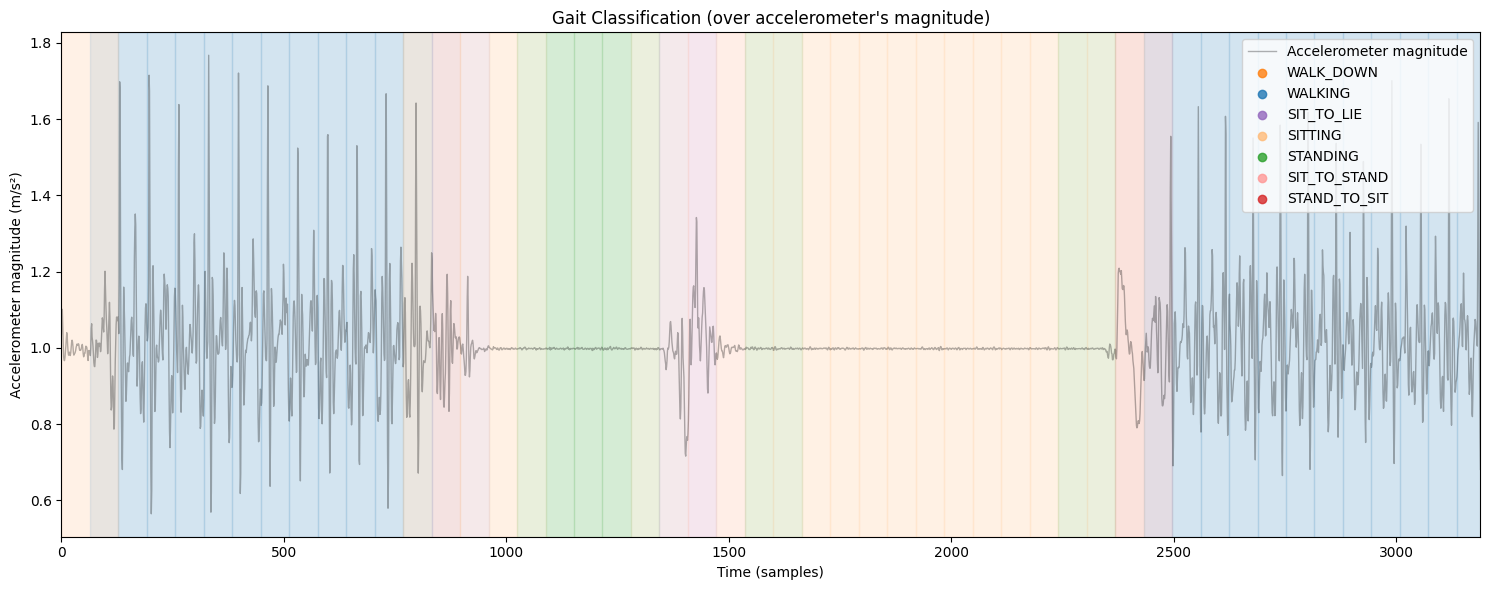

WALKING:	 46.0%
WALK_DOWN:	 4.0%
SITTING:	 30.0%
STANDING:	 12.0%
STAND_TO_SIT:	 2.0%
SIT_TO_STAND:	 2.0%
SIT_TO_LIE:	 4.0%


In [43]:
def gait_classification(acc_path, gyro_path, fs=50, win_size=128, win_overlap=64):
    
    # load custom data
    try:
        acc_data = pd.read_csv(acc_path, header=0, names=['time','x','y','z'], usecols=['x','y','z'])
        gyro_data = pd.read_csv(gyro_path, header=0, names=['time','x','y','z'], usecols=['x','y','z'])
    except FileNotFoundError:
        print("Files not found. Please upload 'Accelerometer.csv' and 'Gyroscope.csv'.")
        return
    
    # normalize accelerometer with respect to g = 9.90665
    acc_data[['x', 'y', 'z']] = acc_data[['x', 'y', 'z']] / 9.80665

    # remove gravity from acc_data
    body_acc, gravity = separate_gravity(acc_data, fs)
    full_signal = np.hstack([body_acc, gyro_data, acc_data])
    
    raw_windows_phy = []
    features_phy = []
    
    for i in range(0, len(full_signal) - win_size, win_overlap):
        window = full_signal[i : i + win_size]
        
        raw_windows_phy.append(window)
        features_phy.append(extract_features(window))

    # create tensors
    # transpose raw: (win_number, channels, win_length)
    X_raw_phy = np.array(raw_windows_phy).transpose(0, 2, 1)
    
    # transform and scale features
    # IMPORTANT: use the same scaler as used before (on the training data)!
    X_feat_phy = scaler.transform(np.array(features_phy))

    # run inference
    model.eval()
    with torch.no_grad():
        t_raw = torch.FloatTensor(X_raw_phy).to(device)
        t_feat = torch.FloatTensor(X_feat_phy).to(device)
        
        outputs = model(t_raw, t_feat)
        _, predictions = torch.max(outputs, 1)

    # visualize classification
    plot_gait_classification(acc_data, predictions)

    # print statistics
    unique_classes, counts = np.unique(predictions.cpu().numpy(), return_counts=True)
    total_counts = sum(counts)
    
    for cls_idx, count in zip(unique_classes, counts):
        percentage = (count / total_counts) * 100
        label_name = HAPT_LABELS.get(cls_idx, "Unknown")
        print(f"{label_name}:\t {percentage:.1f}%")

# run classification
gait_classification("Accelerometer_2.csv", "Gyroscope_2.csv")